In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Inference using PyMC3:
## Case study for Coin toss and Insurance Claim occurence

My last post was [an introduction to Bayes' theorem and bayesian inference by hand](https://bpostance.github.io/tutorial/mathematics/2020/12/13/introduction-to-bayesian-inference.htmlhttps://bpostance.github.io/tutorial/mathematics/2020/12/13/introduction-to-bayesian-inference.html). There we looked at a simple coin toss scenario, modelling each step by hand, to conclude that we had a bias coin bias with posterior probaility of landing tails *P(Tails|Observed Data) = 0.36*.

This time we will run: i) the same coin-toss scenario again, and ii) an example for poisson insurance claim counts, usings the probabilistic programming package [PyMC3](https://docs.pymc.io/https://docs.pymc.io/). An alternative would be to use the equally popular Stanford "Stan"package and its python wrapper [PyStan](https://pystan.readthedocs.io/en/latest/index.htmlhttps://pystan.readthedocs.io/en/latest/index.html). These packages provide an easy to use and intuitive frameworks for developing complex models of data generative processes. In addition, easy access to [Markov Chain Monte Carlo](https://twiecki.io/blog/2015/11/10/mcmc-sampling/https://twiecki.io/blog/2015/11/10/mcmc-sampling/) sampling algorithms.

Recall that our initial approach to Bayesian Inference followed:
 1. Set prior assumptions and establish "known knowns" of our data based on heuristics, historical or sample data. 
 1. Formalise a Mathematical Model of the problem space and prior assumptions.
 1. Formalise the Prior Distributions.
 1. Apply Bayes’ theorem to derive the posterior parameter values from observed sample data.
 1. Repeat steps 1-4 as more data samples are obtained.

Using PyMC3 we can now simplify and condense these steps down.

***First, we set our prior belief and prior beta-binomial distribution.***

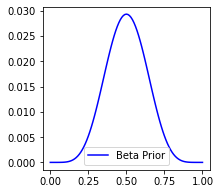

In [2]:
# prior estimates
from scipy.stats import beta

# prior belief of landling tails given coin is unbias
prior = 0.5
theta = np.arange(0,1.01,.01)

# beta-binomial prior distribution
a,b=7,7
prior_beta  = beta(a,b)
prior_beta = prior_beta.pdf(theta) / prior_beta.pdf(theta).sum() # sample integral pmf

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.plot(theta,prior_beta,'b',label='Beta Prior')
plt.legend();

***Second, we define and inspect our sample observation data***

In [3]:
# observation data
trials = 50
tails = 15
heads = trials-tails
print(f"Trials:\t{trials}\ntails:\t{tails}\nheads:\t{heads}")
print(f'Observed P(tails) = {tails/trials}')

Trials:	50
tails:	15
heads:	35
Observed P(tails) = 0.3


***Third, we define and run our mathematical model***

Notice, PyMC3 provides a clean and efficient syntax for describing prior distributions and observational data from which we can include or seperately initiate the model sampling. Also notice that PyMC3 allows us to define priors, introduce sample observation data, and initiate posterior simulation in the same cell call.

In [4]:
import pymc3 as pm

with pm.Model() as model:
    
    # Define the prior beta distrituion
    theta_prior = pm.Beta('prior', a,b)
    
    # Observed outcomes in the sample dataset.
    observations = pm.Binomial('obs',
                               n = trials,
                               p = theta_prior,
                               observed = tails)
     
    # NUTS, the No U-Turn Sampler (Hamiltonian)
    step = pm.NUTS()     
    # Evaluate draws=n on chains=n 
    trace = pm.sample(draws=500,step=step,chains=2,progressbar=True)  
model

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [prior]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2145.48draws/s]


Or with more sampling and across more chains. Then the trace summary returns usefull summary statistics of model performance:
 - mc_error estimates simulation error by breaking the trace into batches, computing the mean of each batch, and then the standard deviation of these means.
 - hpd_* gives highest posterior density intervals. The 2.5 and 97.5 labels are a bit misleading. There are lots of 95% credible intevals, depending on the relative weights of the left and right tails. The 95% HPD interval is the narrowest among these 95% intervals.
 - Rhat is sometimes called the potential scale reduction factor, and gives us a factor by which the variance might be reduced, if our MCMC chains had been longer. It's computed in terms of the variance between chains vs within each chain. Values near 1 are good.

In [5]:
with model:    
    # Evaluate draws=n on chains=n 
    trace = pm.sample(draws=1500,chains=3)
summary = pm.summary(trace)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [prior]
Sampling 3 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3186.22draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prior,0.343,0.057,0.236,0.455,0.001,0.001,1793.0,1793.0,1775.0,2832.0,1.0


We use the trace to manually plot and compare the prior and posterior distributions. Confirming these are similar to what was obtained by hand with a posterior distribution mean of *P(Tails|Observed Data) = 0.35*.

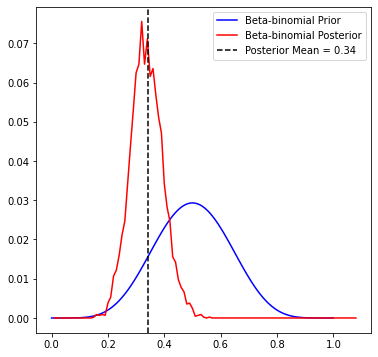

In [6]:
bins = np.arange(0.01,1.1,0.01)

#plot the histogram of click through rates
plt.rcParams['figure.figsize'] = (6,6)

#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior'],bins=bins)  
posterior_counts = posterior_counts / float(posterior_counts.sum()) #normalized histogram

# average posterior value
most_plausible_theta = summary['mean'].values[0] # == np.mean(trace['prior'])

#plot
f, ax = plt.subplots(1)

#ax.plot(possible_theta_values, likelihoods)
ax.plot(theta,prior_beta,c='b',label='Beta-binomial Prior')
ax.plot(bins[:-1],posterior_counts,c='r',label='Beta-binomial Posterior')
ax.axvline(most_plausible_theta, linestyle = "--",c='k', label=f'Posterior Mean = {most_plausible_theta:.2f}')

ax.legend()
plt.show()

However, PyMC3 also provides functionality to create trace plots, posterio distribution plot, credible intervals, plus many more (e.g. see [official docs](https://docs.pymc.io/api/plots.html) and useful examples [here](https://rlhick.people.wm.edu/stories/bayesian_7.html)).

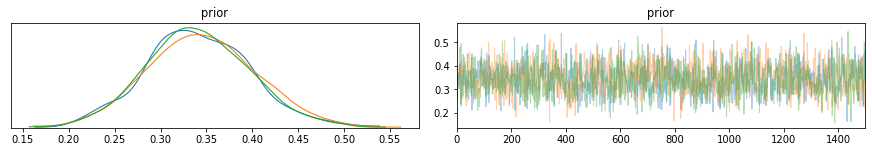

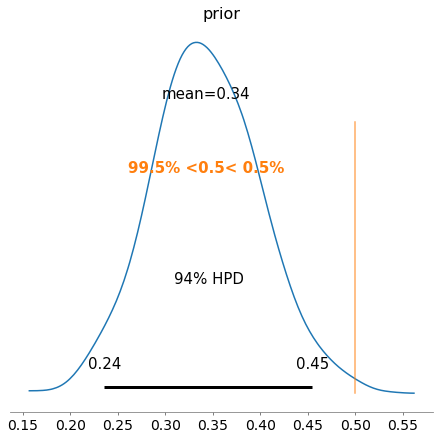

In [7]:
# note there are a few user warnings on using pymc3.traceplot() with pyplot
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)
    pm.plot_posterior(trace,ref_val=0.5);

And there we have it. PyMC3, and other similar packages, offer an easy set of functions to assemble and run probabilistic simulations such as Bayesian Inference. Below I will show one more example for Insurance claim counts.

## Example: Evaluating Insurance claim occurences using Bayesian Inference


Insurance claims are typically modelled as occuring due to a [Poisson distributed](https://en.wikipedia.org/wiki/Poisson_distributionhttps://en.wikipedia.org/wiki/Poisson_distribution) process. A discrete probability distribution that gives the expected number of events (e.g. claims) to occuring within a time interval (e.g. per year). The Poisson distribution has many applications such as modelling machine component failure rates, customer arrival rates, website traffic, and storm events. First, we will run this through by hand as before and then using PyMC3.


The Poisson distribution is given by:

$$f(y_i|λ)=\frac{e^{−λ}λ^{y_i}}{y_i!}$$

Where lambda λ is the "rate" of events given by the total number of events (k) divided by the number of units (n) in the data (λ = k/n). In the Poisson disribution the expected value E(Y), mean E(X), and variance Var(Y) of Poisson distribution are the same; 

e.g., E(Y) = E(X) = Var(X) = λ. 

**Note** that if the variance is greater than the mean, the data is said to be overdispersed. This is common in insurance claim data with lots of zeros and is better handled by the NegativeBinomial and [zero-inflated models](https://stats.idre.ucla.edu/r/dae/zip/) such as ZIP and ZINB.

Here we generate some observed data that follows a poisson distribution with a rate, lambda, λ = 2.

Mean=2.04, Var=2.03


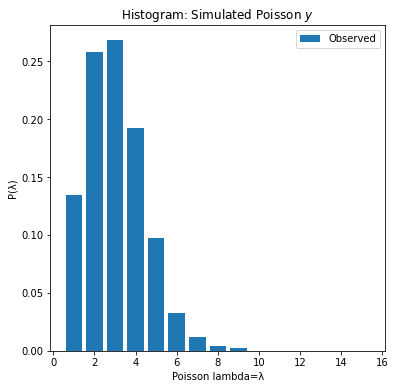

In [8]:
n = 1000
lam_ = 2
y = np.random.poisson(lam=lam_,size=n)
bins = np.arange(0,16,1)

print("Mean={:.2f}, Var={:.2f}".format(np.mean(y),np.var(y)))

# compute histogram
obs_,bins = np.histogram(y,bins=bins,density=True)

# plot
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.bar(bins[1:],obs_,label='Observed')
axs.set_title('Histogram: Simulated Poisson $y$')
axs.set_xlabel('Poisson lambda=λ')
axs.set_ylabel('P(λ)')
axs.legend();

The observed poisson generated data has a right-skew "heavy tail". It looks like a gamma distribution. The [gamma-poisson model](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Gammapoisson.pdf) is a poisson distribution where λ lambda is gamma distribution. The gamma-poisson distributions form a [conjugate prior](https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.htmlhttps://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html). 

We could use a beta-poisson, or any distribution that resembles the shape the observed lambda data, however gamma-poisson is most suitable as: 
- poisson can take on any positive number to infinity(0,∞), whereas a beta or uniform is [0-100]. 
- gamma and poisson are in the same distribution family.
- gamma has a peak close to zero.
- gamma tail goes to infinity.


[Hyvönen & Tolonen 2019](https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html)

The gamma-poisson prior is then:

$$λ∼Γ(a,b)$$

Where a is the gamma shape and b is the gamma rate parameter. The gamma density functions is:

$$f(λ)=\frac{b^a}{Γ(a)}λ^{a−1}e^{−bλ}$$

where a>0 is the shape parameter,and b>0 is the rate parameter, and 

$$E(λ)=\frac{a}{b}$$ 
and 
$$Var(λ)=\frac{a}{b^2}$$

***Note*** In scipy the gamma distribution uses the Shape *a* and Scale parameterisation, where rate *b* is equal to inverse of scale (rate = 1/scale). See more detial on scipy.gamma in the [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html), and in these SO answers [1](https://stackoverflow.com/a/2896284/4538066),[2](https://stackoverflow.com/a/29208871/4538066),[3](https://stackoverflow.com/a/29902949/4538066).

Shape alpha:3.51
Loc:-0.76
Scale beta:0.80
Rate:1.25


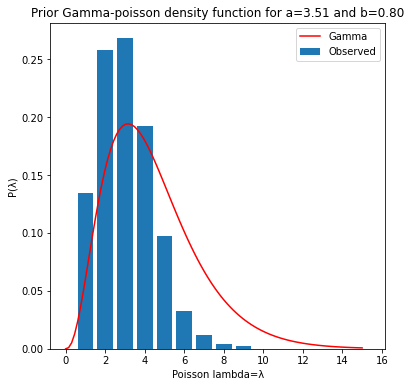

In [9]:
# Parameters of the prior gamma distribution.
# shape, loc, scale == alpha,loc,beta
a, loc, b = stats.gamma.fit(data=y)
rate = 1/b # stats.gamma.fit(y)[2] ==  rate = 1/scale
print('Shape alpha:{:.2f}\nLoc:{:.2f}\nScale beta:{:.2f}\nRate:{:.2f}'.format(a, loc, b, rate))

# options for lambda
x = np.linspace(start=0, stop=15, num=100) 

# Define the prior distribution.
prior = lambda x: stats.gamma.pdf(x, a=a, scale=rate,loc=0)
priors = prior(x)

# plot
axs.plot(x, priors, 'r-',label='Gamma')
axs.set_title('Prior Gamma-poisson density function for a={:.2f} and b={:.2f}'.format(a,b))
axs.set_xlabel('Poisson lambda=λ')
axs.set_ylabel('P(λ)')
axs.legend()
fig

### likelihood function

The gamma function is often referred to as the generalized factorial since:

$$Γ(n+1) = n!$$

In [10]:
import math
import scipy.special as sp

# generalised gamma == factorial
n = 3
sp.gamma(n+1) == math.factorial(n)

True

then the likelihood function is:

$$f(y|λ)=\prod_{i=1}^{n}\frac{e^{−λ}λ^{λ_i}}{y_i!} = \frac{e^{-nλ}λ\sum_{i=1}^{n}y_i}{\prod_{i=1}^{n}y_i!}$$

In [11]:
# likelihood function
def likelihood(lam,y):
    """ Gamma-poisson likelihood function"""
    
    factorials = np.apply_along_axis(
                    func1d=lambda Yi: sp.gamma(Yi+1),
                    axis=0,
                    arr=y)
    
    # exponential (-lambda*n) * (lambda**sum(y))
    numerator = np.exp(-lam*y.size)*(lam**y.sum())
    
    # product of gamma (aka factorial) of y
    denominator = np.multiply.reduce(factorials)
    
    # likelihoods, remove zeros
    l = np.array(numerator/denominator)
    l[np.isnan(l)] = 0.0
    return l

In [12]:
# Define the posterior distribution.
def posterior_up_to_constant(lam,y):
    return likelihood(lam,y)*prior(lam)

# calculate posteriors and normalise
Cposteriors =  posterior_up_to_constant(x,y)
Cposteriors = Cposteriors/Cposteriors.sum()

then as
$$f(λ|y)∝λ^(\sum_{i=1}^{n}y_i+a)^{−1}e^{−(n+b)λ}$$ 
the posterior distribution is again a gamma

$$f(λ|y)=Γ\big(\sum_{i=1}^{n}y_i+a,n+b\big)$$

In [13]:
def posterior(lam,y):
    
    shape = a + y.sum()
    rate = b + y.size
    
    return stats.gamma.pdf(lam, shape, scale=1/rate)

posterior = posterior(x,y)

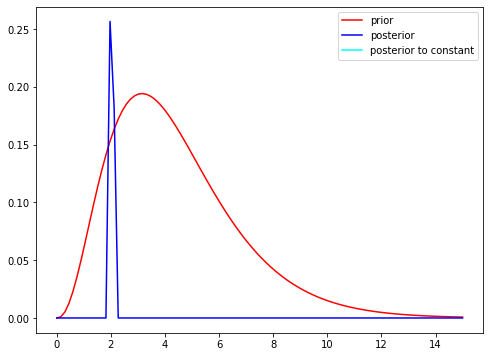

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(x, priors, 'r-', label='prior')
plt.plot(x, 0.1*posterior,c='blue', label='posterior')
plt.plot(x, Cposteriors,c='cyan', label='posterior to constant')
plt.legend();

As shown the the posterior mean (blue) is centered around the true lambda rate that we set at the start. The posterior mean is:

$$\frac{\sum_{i=1}^{n}y_i+a}{n+b}$$

i.e. the posterior mean is a weighted average of the prior mean and the observed sample average $\bar{y}$

In [15]:
print(f"""True lambda: {lam_}
prior mean: {a/b}
posterior mean: {(a+y.sum()) / (b+y.size)}
sample mean:{y.mean()}""")


True lambda: 2
prior mean: 4.406142620913817
posterior mean: 2.0408855867928644
sample mean:2.039


Now lets re-produce the steps above in PyMC3. 

In [16]:
# known initial params
a,b,lam_,y.shape

(3.5125841350931166, 0.7972016426387533, 2, (1000,))

In [17]:
model = pm.Model()

with model:
    
    # Define the prior of the parameter lambda.
    prior_lam = pm.Gamma('prior-gamma-lambda', alpha=a, beta=b)
    
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=prior_lam, observed=y)
    
    # Consider 2000 draws and 3 chains.
    trace = pm.sample(draws=2000, chains=3)

summary = pm.summary(trace)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [prior-gamma-lambda]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:02<00:00, 3101.04draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prior-gamma-lambda,2.04,0.045,1.954,2.124,0.001,0.001,2487.0,2485.0,2483.0,3839.0,1.0


The above configuration simulates the posterior distribution for 3 independent Markov-Chains (traces). The traceplots display the results for each simulation. 

Below the mean, quantile, credible interval (HPD) 94%, and arbitary reference value (orange vertical).

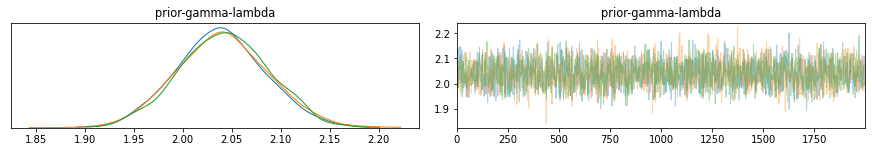

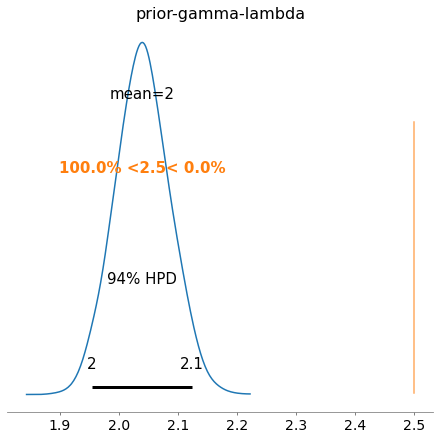

In [18]:
# note there are a few user warnings on using pymc3.traceplot() with pyplot
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)
    pm.plot_posterior(trace,ref_val=2.5);

### references
- https://twiecki.io/blog/2015/11/10/mcmc-sampling/https://twiecki.io/blog/2015/11/10/mcmc-sampling/
- https://docs.pymc.io/https://docs.pymc.io/
- https://pystan.readthedocs.io/en/latest/index.htmlhttps://pystan.readthedocs.io/en/latest/index.html
- https://www.sciencedirect.com/science/article/abs/pii/S0740002005000249
- https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html
- https://www.coursera.org/learn/mcmc-bayesian-statistics
